## Estimating lifespan normative models

This notebook provides a complete walkthrough for an analysis of normative modelling using your own dataset. Training and testing data is provided for this tutorial. However, the idea is that you could subsitute our provided training and testing datasets for you own dataset (as long as it matches the same format!)

First, if necessary, we install PCNtoolkit (note: this tutorial requires at least version 0.20)

### Préparation de l'environnement

In [372]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
! rm -r '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/'
! mkdir '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/'

In [2]:
import os
os.chdir('/Users/ltran/Documents/TrueData29/CPC_ML_tutorial/')

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import random

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d
from sklearn.model_selection import train_test_split

# Dossier contenant les données
data_dir = '/Users/ltran/Documents/Data/'

# Dossier pour faire l'analyse
root_dir = '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/'
out_dir = os.path.join(root_dir,'models','test')

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

# PREPARATION DONNEES

### Données RBD

In [3]:
# Charger données pour RBD
Scan_rbd = pd.read_csv(os.path.join(data_dir,'TSA_cohort_dcm_info_anonymized.csv'), sep = '\t')
lh_rbd = pd.read_csv(os.path.join(data_dir,'fs-6.0.0-tfe.lh.thickness.csv'), sep = '\t')
rh_rbd = pd.read_csv(os.path.join(data_dir,'fs-6.0.0-tfe.rh.thickness.csv'), sep = '\t')
part_rbd =pd.read_csv(os.path.join(data_dir,'participants_bids.csv'),encoding='unicode_escape', sep = ';')

In [4]:
# Merge info scanner avec info participants
# Retire les individus pour lesquels info age et/ou sexe manquant
# Met 'sex' en format int
Scan_rbd['participant_id'] = Scan_rbd['SubCode BIDS']
df_participants_rbd = part_rbd.merge(Scan_rbd[['participant_id', 'magnetic_field_strength']], on = "participant_id", how = "inner" ).dropna(subset = ['sex', 'age_at_first_scan'])
df_participants_rbd['sex'] = df_participants_rbd['sex'].replace({'F' : -1, 'M' : 1})


In [5]:
# Met ids BIDS dans le bon format
l_part_id = []
for i in lh_rbd['lh.aparc.thickness']:
    
    l_part_id.append(int(i.split('-')[1].split('_')[0].lstrip('0')))
lh_rbd['participant_id'] = l_part_id

# Merge LH, RH, Participants, Scanner
df_rbd = lh_rbd.join(rh_rbd.drop(columns = ['BrainSegVolNotVent', 'eTIV'])).merge(df_participants_rbd, on = 'participant_id', how = 'inner')


In [6]:
# Garder un seul scan par individu (enlève duplicata)
df_rbd = df_rbd.drop_duplicates(subset = 'participant_id')


### Données EU-AIMS

In [7]:
# Charger données EU-AIMS
QC = pd.read_csv(os.path.join(data_dir,'QC_LEAP_freesurfer_preproc_info.csv'), sep = ';')

leap = pd.read_csv(os.path.join(data_dir,'LEAP_CorticalMeasuresENIGMA_ThickAvg.csv'), sep = ';')

cov = pd.read_csv(os.path.join(data_dir,'Core_variables_03_09_19_withvalues_internal.tsv'), sep = '\t')

In [8]:
# Merge scores autisme avec QC, en ne gardant que les "include"
df_cov_aims = cov.merge(QC.loc[QC['final_decision_bin'] == "include"], on = "participant_id", how = "inner")

In [9]:
# Formate ID
l_id  = []
for i in leap['SubjID']:
    l_id.append(int(i.split('_')[1]))

leap['participant_id'] = l_id

In [10]:
# Merge thickness avec scores autisme+QC
df_aims = leap.merge(df_cov_aims, on = 'participant_id', how = 'inner')

## Données poolées EU-AIMS et RBD

In [11]:
# Renome les colonnes de EU-AIMS pour matcher avec les nom de colonne de RBD
df_aims.columns = df_aims.columns.str.replace('L_','lh_')
df_aims.columns = df_aims.columns.str.replace('_thickavg','_thickness')
df_aims.columns = df_aims.columns.str.replace('R_','rh_')

df_aims = df_aims.rename(columns = {'t1_ageyrs' : 'age_at_first_scan', 't1_sex' : 'sex', 't1_fsiq' : 'Total_IQ'})
df_aims['ASD'] = df_aims['t1_diagnosis'].replace({1 : 'No', 2 : 'Yes'})

In [12]:
# Rajoute site à RBD
df_rbd['site'] = 'RBD'
df_rbd['t1_site'] = 9 

In [13]:
# Extrait nom des régions pour merge
cols_rbd = [col for col in df_rbd.columns if '_thick' in col]

cols_rbd.remove('rh_MeanThickness_thickness')
cols_rbd.remove('lh_MeanThickness_thickness')

In [14]:
df_all = df_aims.merge(df_rbd, on = cols_rbd.append(['age_at_first_scan', 'sex', 'site', 't1_site']), how = 'outer')
df_all

,SubjID,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,...,cognitive_level,Max_IQ,Performance_IQ,Verbal_IQ,developmental_quotient,abide2_code,DNA_Fusion_code,MRI_code_old,Unnamed: 16,magnetic_field_strength
0,PCS2_100693509718,2.650,2.386,2.736,1.870,3.599,3.067,2.410,3.077,2.633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PCS2_101129844643,2.966,3.473,2.703,2.066,3.766,3.198,2.881,3.143,2.705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PCS2_101414625982,3.051,3.020,3.120,2.411,3.189,3.232,2.804,3.417,2.692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PCS2_101900205031,2.874,2.838,2.698,2.115,3.353,3.140,2.650,3.152,2.665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PCS2_104324981539,2.941,3.416,2.483,2.298,3.431,2.928,2.711,3.156,2.886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,NaN,2.366,2.758,2.377,1.761,3.597,2.857,2.283,2.977,2.482,...,NaN,NaN,NaN,NaN,NaN,NaN,C0733-011-000-256,MRIPasteur-1055,NaN,1_5
1223,NaN,2.703,2.539,2.498,2.097,3.279,2.590,2.500,2.954,2.152,...,NaN,NaN,NaN,NaN,NaN,NaN,C0733-011-196-001,MRIPasteur-1057,NaN,1_5
1224,NaN,2.748,2.839,2.470,1.984,3.913,2.931,2.609,3.205,2.355,...,NaN,NaN,NaN,NaN,NaN,NaN,C0733-011-196-005,MRIPasteur-1058,NaN,1_5
1225,NaN,2.507,2.861,2.737,1.979,3.703,2.591,2.658,2.958,2.474,...,NaN,NaN,NaN,NaN,NaN,NaN,C0733-011-196-004,MRIPasteur-1059,NaN,1_5


# CHOIX ROIs

In [15]:
all_cols = [col for col in df_all.columns if '_thick' in col]
all_cols.remove('lh_MeanThickness_thickness')
all_cols.remove('rh_MeanThickness_thickness')

In [16]:
print('Nombre de régions : ', len(all_cols))

Nombre de régions :  68


### // SOMME SUR RÉGIONS

In [238]:
Lcols = [col for col in all_cols if 'lh_' in col]
Rcols = [col for col in all_cols if 'rh_' in col]

df_all['L_sum'] = df_all[Lcols].sum(axis = 1)
df_all['R_sum'] = df_all[Rcols].sum(axis =1)
df_all['T_sum'] = df_all[all_cols].sum(axis = 1)

# PLOT DONNEES BRUTES

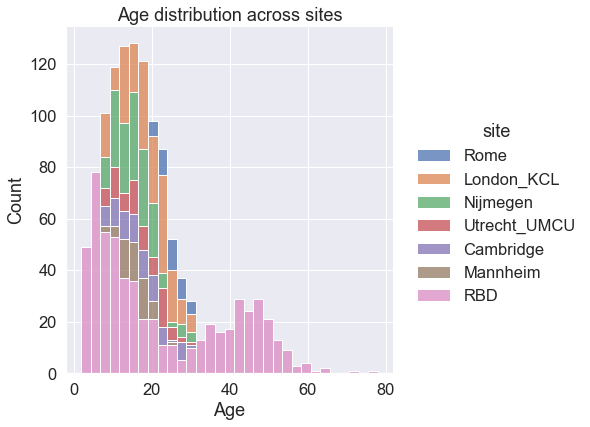

In [17]:
sns.set(font_scale=1.5, style='darkgrid')
sns.displot(df_all, x="age_at_first_scan", hue="site", multiple="stack", height=6).set(xlabel = 'Age', title = 'Age distribution across sites')

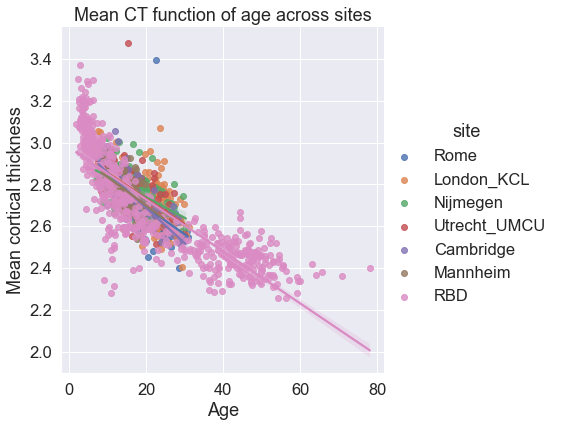

In [18]:
df_all_avg = df_all.copy()
df_all_avg['Avg'] = df_all_avg[all_cols].mean(axis = 1)

sns.set_theme(style="darkgrid",font_scale=1.5)
c = sns.lmplot(data=df_all_avg, x="age_at_first_scan", y='Avg', hue="site", height=6).set(xlabel = 'Age', ylabel = 'Mean cortical thickness', title = 'Mean CT function of age across sites')

plt.show()

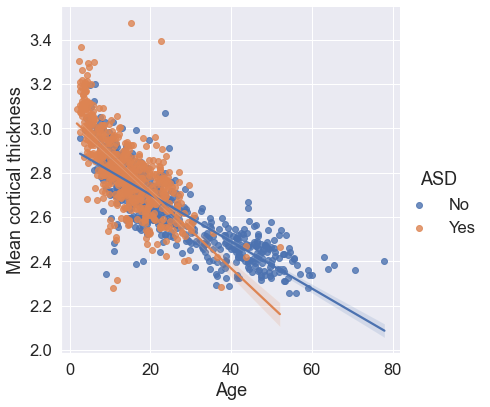

In [19]:
sns.set_theme(style="darkgrid",font_scale=1.5)
c = sns.lmplot(data=df_all_avg, x="age_at_first_scan", y='Avg', hue="ASD", height=6).set(xlabel = 'Age', ylabel = 'Mean cortical thickness')

plt.show()

## DataFrames

In [21]:
# Initialise tableau des métriques
metric_analysis = pd.DataFrame(columns = ['ROIs', 'EV mean', 'EV max', 'MSLL mean', 'MSLL min', 'Covs', 'Fixed effect', 'xmin', 'xmax', 'Outlier Thresh'])

### // Si on utilise Total IQ comme covariable...

In [655]:
# Clean NA pour total IQ
df_all = df_all.dropna(subset = ['Total_IQ'])
df_control = df_all[df_all['ASD'] == 'No']
df_asd = df_all[df_all['ASD'] == 'Yes']

### Si on utilise juste Age + Sex comme covariable...

In [22]:
df_control = df_all[df_all['ASD'] == 'No']
df_asd = df_all[df_all['ASD'] == 'Yes']

# CHOIX DE COVARIABLES ET PARAMETRES DU MODELE

In [23]:
# Choix des covariables
cols_cov = ['age_at_first_scan','sex']
fixed_effect = 'site'

# Choix variable de réponse
idp_ids = all_cols

# Type de déformation 
warp =  'WarpSinArcsinh'


# Limites B-spline
xmin = -6 # ~ age min - 5 
xmax = 87 # ~ age max + 5

force_refit = True 

# Seuil outlier
outlier_thresh = 5


In [24]:
# Vérifie qu'on a pas de NA dans nos covariables
df_all[cols_cov].isna().sum()

age_at_first_scan    0
sex                  0
dtype: int64

# FIT MODEL 

In [25]:
pred_bool = input("Prédiction sur TD + ASD : 1 \nPrédiction sur ASD uniquement : 2\n")

Prédiction sur TD + ASD : 1 
Prédiction sur ASD uniquement : 2
2


In [41]:
# Définir le nombre de bootstrap. 
# Mettre 1 si pas de bootstrap
n_boot = 1

In [42]:

for i in range(n_boot):
    
    if (pred_bool == '1'):
        
        df_control = df_all[df_all['ASD'] == 'No']

        shuffled = df_control.sample(frac=1)
        result = np.array_split(shuffled, 3)
        df_tr = result[0]
        df_te1 = result[1]
        df_te2 = pd.concat([df_asd, result[2]]).reset_index()
    
    elif (pred_bool == '2'):
        
        shuffled = df_control.sample(frac=1)
        result = np.array_split(shuffled, 2)
        df_tr = result[0]
        df_te1 = result[1]
        df_te2 = df_asd


    site_ids = set(df_all['site'])
    site_ids_tr = set(df_tr['site'])
    site_ids_te = set(df_te1['site'])
    
    
    for idp_num, idp in enumerate(idp_ids): 
        print('Running IDP', idp_num, idp, ':')

        # set output dir 
        idp_dir = os.path.join(out_dir, idp)
        os.makedirs(os.path.join(idp_dir), exist_ok=True)
        os.chdir(idp_dir)

        # extract the response variables for training and test set
        y_tr = df_tr[idp].to_numpy() 
        y_te = df_te1[idp].to_numpy()

        # remove gross outliers and implausible values
        yz_tr = (y_tr - np.mean(y_tr)) / np.std(y_tr)
        yz_te = (y_te - np.mean(y_te)) / np.std(y_te)
        nz_tr = np.bitwise_and(np.abs(yz_tr) < outlier_thresh, y_tr > 0)
        nz_te = np.bitwise_and(np.abs(yz_te) < outlier_thresh, y_te > 0)
        y_tr = y_tr[nz_tr]
        y_te = y_te[nz_te]

        # write out the response variables for training and test
        resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
        resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
        np.savetxt(resp_file_tr, y_tr)
        np.savetxt(resp_file_te, y_te)

        # configure the design matrix
        X_tr = create_design_matrix(df_tr[cols_cov].loc[nz_tr], 
                                    site_ids = df_tr['site'].loc[nz_tr],
                                    basis = 'bspline', 
                                    xmin = xmin, 
                                    xmax = xmax)
        X_te = create_design_matrix(df_te1[cols_cov].loc[nz_te], 
                                    site_ids = df_te1['site'].loc[nz_te], 
                                    all_sites=site_ids,
                                    basis = 'bspline', 
                                    xmin = xmin, 
                                    xmax = xmax)

        # configure and save the covariates
        cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
        cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
        np.savetxt(cov_file_tr, X_tr)
        np.savetxt(cov_file_te, X_te)

        if not force_refit and os.path.exists(os.path.join(idp_dir, 'Models', 'NM_0_0_estimate.pkl')):
            print('Making predictions using a pre-existing model...')
            suffix = 'predict'

            # Make prdictsion with test data
            predict(cov_file_te, 
                    alg='blr', 
                    respfile=resp_file_te, 
                    model_path=os.path.join(idp_dir,'Models'),
                    outputsuffix=suffix)
        else:
            print('Estimating the normative model...')
            estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
                     testcov=cov_file_te, alg='blr', optimizer = 'l-bfgs-b', 
                     savemodel=True, warp=warp, warp_reparam=True)
            suffix = 'estimate'
    blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])

    for idp_num, idp in enumerate(idp_ids): 
        idp_dir = os.path.join(out_dir, idp)

        # load the predictions and true data. We use a custom function that ensures 2d arrays
        # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # compute error metrics
        if warp is None:
            metrics = evaluate(y_te, yhat_te)  

            # compute MSLL manually as a sanity check
            y_tr_mean = np.array( [[np.mean(y_tr)]] )
            y_tr_var = np.array( [[np.var(y_tr)]] )
            MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
        else:
            warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
            W = nm.blr.warp

            # warp predictions
            med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
            med_te = med_te[:, np.newaxis]

            # evaluation metrics
            metrics = evaluate(y_te, med_te)

            # compute MSLL manually
            y_te_w = W.f(y_te, warp_param)
            y_tr_w = W.f(y_tr, warp_param)
            y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
            y_tr_var = np.array( [[np.var(y_tr_w)]] )
            MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     

        Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
        [skew, sdskew, kurtosis, sdkurtfddfosis, semean, sesd] = calibration_descriptives(Z)

        BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik

        blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                             MSLL[0], BIC, skew, kurtosis]

    display(blr_metrics)

    blr_metrics.to_csv(os.path.join(out_dir,'blr_metrics.csv'))
    new_row = {'ROIs' : len(idp_ids) , 'EV mean': blr_metrics['EV'].mean(), 'EV max' : blr_metrics['EV'].max() , 'MSLL mean': blr_metrics['MSLL'].mean(), 'MSLL min' : blr_metrics['MSLL'].min(), 'Covs' : cols_cov, 'Fixed effect' : fixed_effect , 'xmin' : xmin, 'xmax' : xmax, 'Outlier Thresh' : outlier_thresh}
    metric_analysis = metric_analysis.append(new_row, ignore_index=True)

Running IDP 0 lh_bankssts_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_bankssts_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 1 lh_caudalanteriorcingulate_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6765e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17362e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.34224e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.01814e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_caudalanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 2 lh_caudalmiddlefrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_caudalmiddlefrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 3 lh_cuneus_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_cuneus_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model 

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.54735e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.81019e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.99423e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.83394e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 6 lh_inferiorparietal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_inferiorparietal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.20056e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.6338e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.62307e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.30932e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 7 lh_inferiortemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_inferiortemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 8 lh_isthmuscingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_isthmuscingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 9 lh_lateraloccipital_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_lateraloccipital_thickness/resp_tr.txt
Estima

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.00154e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.13821e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.67721e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 10 lh_lateralorbitofrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_lateralorbitofrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 11 lh_lingual_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.83906e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.27913e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.66325e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_lingual_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 12 lh_medialorbitofrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_medialorbitofrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.47528e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.88964e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.92851e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.15984e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 13 lh_middletemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_middletemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 14 lh_parahippocampal_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.23549e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.62232e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.56779e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.10094e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_parahippocampal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 15 lh_paracentral_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_paracentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.36036e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.32925e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.16595e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17694e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 16 lh_parsopercularis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_parsopercularis_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 17 lh_parsorbitalis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_parsorbitalis_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 18 lh_parstriangularis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_parstriangularis_thickness/resp_tr.txt
Estimating 

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.8366e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.38376e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.62716e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_pericalcarine_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 20 lh_postcentral_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_postcentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 21 lh_posteriorcingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_posteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model 

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.62134e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.2635e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.69693e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_precentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 23 lh_precuneus_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.37238e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.58928e-23): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.8505e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.52061e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_precuneus_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 24 lh_rostralanteriorcingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_rostralanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 25 lh_rostralmiddlefrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_rostralmiddlefrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.9615e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.16368e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.60954e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.46865e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 26 lh_superiorfrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_superiorfrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 27 lh_superiorparietal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_superiorparietal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.49754e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.19502e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.84961e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 28 lh_superiortemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_superiortemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 29 lh_supramarginal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_supramarginal_thickness/resp_tr.txt


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.33739e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.28898e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01604e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 30 lh_frontalpole_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_frontalpole_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.32454e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.65446e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.13857e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.79394e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 31 lh_temporalpole_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_temporalpole_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 32 lh_transversetemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_transversetemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.29461e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.36731e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.05143e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.35536e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 33 lh_insula_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/lh_insula_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 34 rh_bankssts_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_bankssts_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 35 rh_caudalanteriorcingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_caudalanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.14111e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.03096e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.16515e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 36 rh_caudalmiddlefrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_caudalmiddlefrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 37 rh_cuneus_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_cuneus_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 38 rh_entorhinal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_entorhinal_thickness/resp_tr.txt
Estimating model  1 of 1
conf

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.85258e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.96103e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.31945e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.01621e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 39 rh_fusiform_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_fusiform_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 40 rh_inferiorparietal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_inferiorparietal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.76795e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.7928e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.55764e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.84594e-19): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 41 rh_inferiortemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_inferiortemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.34052e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.32402e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.91823e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.02052e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 42 rh_isthmuscingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_isthmuscingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 43 rh_lateraloccipital_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_lateraloccipital_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 44 rh_lateralorbitofrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_lateralorbitofrontal_thickness/resp_tr

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.87614e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.57525e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.01361e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_lingual_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 46 rh_medialorbitofrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_medialorbitofrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 47 rh_middletemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_middletemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the mode

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.03622e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.07944e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.85501e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.62782e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 49 rh_paracentral_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_paracentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 50 rh_parsopercularis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_parsopercularis_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 51 rh_parsorbitalis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_parsorbitalis_thickness/resp_tr.txt
Estimating model  1 o

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.19158e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.89368e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.52882e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.44064e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 52 rh_parstriangularis_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_parstriangularis_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.52919e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.15205e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.13726e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.80785e-18): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 53 rh_pericalcarine_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_pericalcarine_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 54 rh_postcentral_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_postcentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 55 rh_posteriorcingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_posteriorcingulate_thickness/resp_tr.txt
Estimating mode

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.96504e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.15714e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.78237e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 56 rh_precentral_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_precentral_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 57 rh_precuneus_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_precuneus_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.60836e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.05695e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.86747e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.90569e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 58 rh_rostralanteriorcingulate_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_rostralanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 59 rh_rostralmiddlefrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_rostralmiddlefrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 60 rh_superiorfrontal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_superiorfrontal_thi

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.07678e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.26645e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.27537e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.21944e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 61 rh_superiorparietal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_superiorparietal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 62 rh_superiortemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_superiortemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 63 rh_supramarginal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_supramarginal_thickness/resp_tr.txt
Estimatin

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.16945e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.56428e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.48962e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.19056e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 64 rh_frontalpole_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_frontalpole_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 65 rh_temporalpole_thickness :


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.66773e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.22798e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.93546e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.92325e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_temporalpole_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 66 rh_transversetemporal_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_transversetemporal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.56792e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.1736e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.43714e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.37192e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mod

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 67 rh_insula_thickness :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/rh_insula_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...


,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
0,lh_bankssts_thickness,-79.340484,0.431430,-2.796880,-135.683397,-0.519041,1.335100
1,lh_caudalanteriorcingulate_thickness,97.155073,0.286070,-1.743419,217.307718,0.100074,0.215491
2,lh_caudalmiddlefrontal_thickness,-102.872200,0.436987,-2.884417,-182.746827,-0.010605,0.455977
3,lh_cuneus_thickness,-54.445326,0.312554,-8.785894,-85.893080,0.749308,2.179064
4,lh_entorhinal_thickness,121.534310,-0.041268,-0.667871,266.066191,-0.033847,0.120879
...,...,...,...,...,...,...,...
63,rh_supramarginal_thickness,-119.798535,0.539426,-3.052324,-216.599499,-0.293585,0.440590
64,rh_frontalpole_thickness,101.502095,0.293267,-0.960096,226.001762,-0.005368,0.663568
65,rh_temporalpole_thickness,127.956793,-0.259096,-3.441294,278.911158,-0.312519,0.775496
66,rh_transversetemporal_thickness,28.426042,0.342775,-2.372644,79.849656,0.034535,0.985703


## Output : Métriques du modèle

In [43]:
metric_analysis

,ROIs,EV mean,EV max,MSLL mean,MSLL min,Covs,Fixed effect,xmin,xmax,Outlier Thresh
0,68,0.349178,0.585110,-3.468416,-12.636277,"[age_at_first_scan, sex]",site,-6,87,5
1,68,0.347759,0.602910,-3.088551,-11.457267,"[age_at_first_scan, sex]",site,-6,87,5
2,68,0.373958,0.620450,-3.411555,-12.671940,"[age_at_first_scan, sex]",site,-6,87,5
3,68,0.366427,0.650803,-2.893876,-11.153508,"[age_at_first_scan, sex]",site,-6,87,5
4,68,0.372701,0.637088,-3.064590,-11.797556,"[age_at_first_scan, sex]",site,-6,87,5
5,68,0.339854,0.607823,-3.110507,-11.704683,"[age_at_first_scan, sex]",site,-6,87,5
6,68,0.372084,0.661404,-3.230580,-12.176435,"[age_at_first_scan, sex]",site,-6,87,5
7,68,0.363047,0.650571,-3.188330,-12.219518,"[age_at_first_scan, sex]",site,-6,87,5
8,68,0.369725,0.621974,-2.989501,-11.243257,"[age_at_first_scan, sex]",site,-6,87,5
9,68,0.407539,0.675582,-3.708062,-13.184954,"[age_at_first_scan, sex]",site,-6,87,5


In [38]:
metric_analysis.describe()

,EV mean,EV max,MSLL mean,MSLL min
count,21.000000,21.000000,21.000000,21.000000
mean,0.364237,0.628882,-3.099039,-11.708865
std,0.020997,0.025919,0.228724,0.708071
min,0.324549,0.585110,-3.708062,-13.184954
25%,0.350727,0.609691,-3.188330,-12.176435
50%,0.363047,0.621974,-3.088551,-11.704683
75%,0.372701,0.650803,-2.957288,-11.181437
max,0.407539,0.675582,-2.685775,-10.176915


# FAIRE PREDICTIONS

In [44]:
for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    
    # extract and save the response variables for the test set
    y_te = df_te2[idp].to_numpy()
    
    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_te, y_te)

    # configure and save the design matrix
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    X_te = create_design_matrix(df_te2[cols_cov], 
                                site_ids = df_te2['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    np.savetxt(cov_file_te, X_te)
    
    # check whether all sites in the test set are represented in the training set
    if all(elem in site_ids_tr for elem in site_ids_te):
        print('All sites are present in the training data')
        
        # just make predictions
        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg='blr', 
                                    respfile=resp_file_te, 
                                    model_path=os.path.join(idp_dir,'Models'))
    else:
        print('Some sites missing from the training data. Adapting model')
        
        # save the covariates for the adaptation data
        X_ad = create_design_matrix(df_ad[cols_cov], 
                                    site_ids = df_ad['site'],
                                    all_sites = site_ids_tr,
                                    basis = 'bspline', 
                                    xmin = xmin, 
                                    xmax = xmax)
        cov_file_ad = os.path.join(idp_dir, 'cov_bspline_ad.txt')          
        np.savetxt(cov_file_ad, X_ad)
        
        # save the responses for the adaptation data
        resp_file_ad = os.path.join(idp_dir, 'resp_ad.txt') 
        y_ad = df_ad[idp].to_numpy()
        np.savetxt(resp_file_ad, y_ad)
       
        # save the site ids for the adaptation data
        sitenum_file_ad = os.path.join(idp_dir, 'sitenum_ad.txt') 
        site_num_ad = df_ad['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_ad, site_num_ad)
        
        # save the site ids for the test data 
        sitenum_file_te = os.path.join(idp_dir, 'sitenum_te.txt')
        site_num_te = df_te2['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_te, site_num_te)
         
        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg = 'blr', 
                                    respfile = resp_file_te, 
                                    model_path = os.path.join(idp_dir,'Models'),
                                    adaptrespfile = resp_file_ad,
                                    adaptcovfile = cov_file_ad,
                                    adaptvargroupfile = sitenum_file_ad,
                                    testvargroupfile = sitenum_file_te)

Running IDP 0 lh_bankssts_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 lh_caudalanteriorcingulate_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 lh_caudalmiddlefrontal_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 lh_cuneus_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 4 lh_entorhinal_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations

All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 40 rh_inferiorparietal_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 41 rh_inferiortemporal_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 42 rh_isthmuscingulate_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 43 rh_lateraloccipital_thickness :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing

# PLOT

In [45]:
# which sex do we want to plot? 
sex = 1 # 1 = male 0 = female
if sex == 1: 
    clr = 'blue';
else:
    clr = 'red'

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx
X0_dummy[:,1] = sex

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, 
                               site_ids=None, 
                               all_sites=site_ids_tr
                              )

# save the dummy covariates
cov_file_dummy = os.path.join(out_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

configuring dummy data ...


Running IDP 0 lh_bankssts_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.2156919]), 'Rho': array([0.52518314]), 'pRho': array([4.09777418e-46]), 'SMSE': array([0.72432392]), 'EXPV': array([0.27578894])}


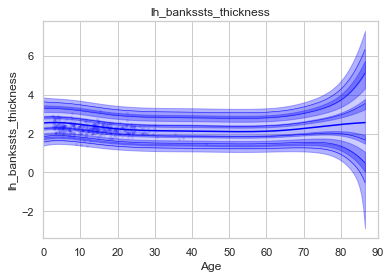

Running IDP 1 lh_caudalanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.32487261]), 'Rho': array([0.15540535]), 'pRho': array([0.00012912]), 'SMSE': array([1.16026577]), 'EXPV': array([-0.14429279])}


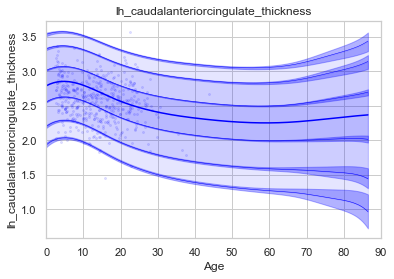

Running IDP 2 lh_caudalmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19888202]), 'Rho': array([0.15997749]), 'pRho': array([8.05725108e-05]), 'SMSE': array([1.03415814]), 'EXPV': array([-0.01022874])}


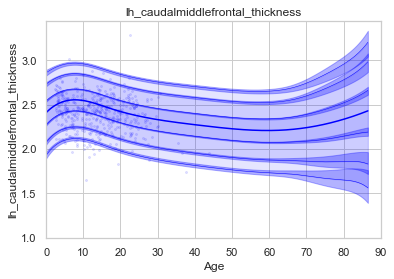

Running IDP 3 lh_cuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22293777]), 'Rho': array([0.51333981]), 'pRho': array([1.10597353e-43]), 'SMSE': array([0.87497439]), 'EXPV': array([0.25762798])}


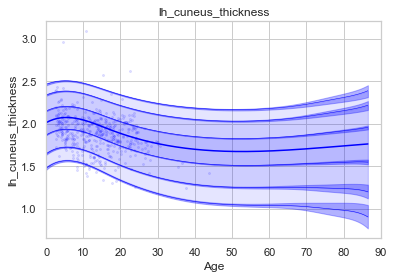

Running IDP 4 lh_entorhinal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.45276805]), 'Rho': array([-0.19498399]), 'pRho': array([1.39337988e-06]), 'SMSE': array([1.43490423]), 'EXPV': array([-0.18011087])}


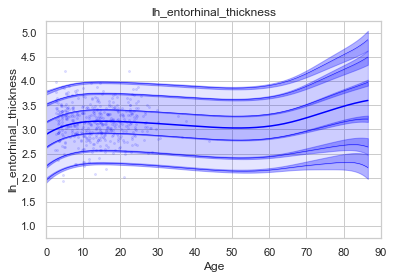

Running IDP 5 lh_fusiform_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16660332]), 'Rho': array([0.58463701]), 'pRho': array([3.82900746e-60]), 'SMSE': array([0.66152957]), 'EXPV': array([0.34149669])}


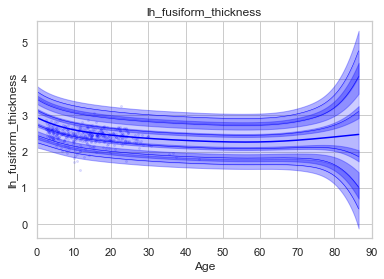

Running IDP 6 lh_inferiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16594604]), 'Rho': array([0.71832973]), 'pRho': array([3.73241987e-108]), 'SMSE': array([0.50434767]), 'EXPV': array([0.50386157])}


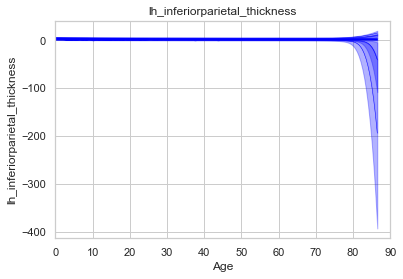

Running IDP 7 lh_inferiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19285717]), 'Rho': array([0.56230211]), 'pRho': array([1.73412386e-54]), 'SMSE': array([0.71896601]), 'EXPV': array([0.3152608])}


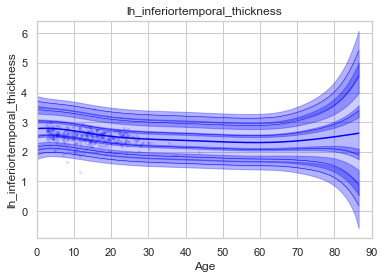

Running IDP 8 lh_isthmuscingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.26380963]), 'Rho': array([0.10528923]), 'pRho': array([0.00981831]), 'SMSE': array([1.08493328]), 'EXPV': array([-0.05766011])}


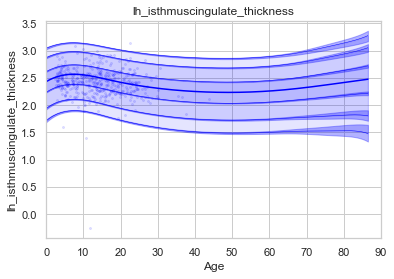

Running IDP 9 lh_lateraloccipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1800678]), 'Rho': array([0.55661292]), 'pRho': array([3.99765481e-53]), 'SMSE': array([0.77782924]), 'EXPV': array([0.30189213])}


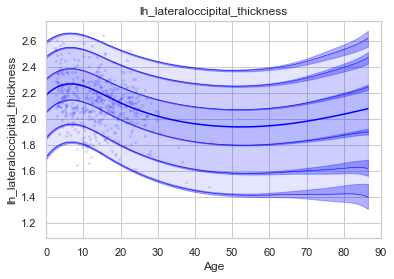

Running IDP 10 lh_lateralorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19290712]), 'Rho': array([0.76451101]), 'pRho': array([1.13932559e-133]), 'SMSE': array([0.4164625]), 'EXPV': array([0.58384459])}


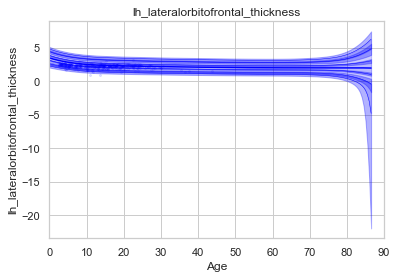

Running IDP 11 lh_lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19953696]), 'Rho': array([0.48115493]), 'pRho': array([1.35009934e-37]), 'SMSE': array([1.00541729]), 'EXPV': array([0.22514658])}


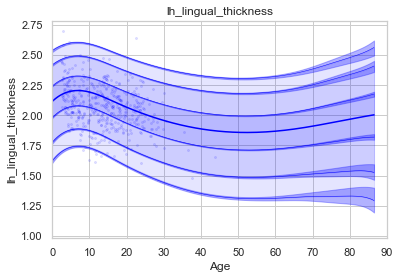

Running IDP 12 lh_medialorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22513364]), 'Rho': array([0.73121186]), 'pRho': array([1.26160833e-114]), 'SMSE': array([0.49524126]), 'EXPV': array([0.53378252])}


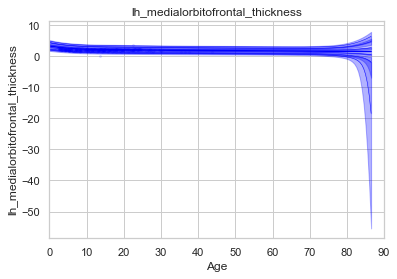

Running IDP 13 lh_middletemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1974588]), 'Rho': array([0.53179576]), 'pRho': array([1.61020015e-47]), 'SMSE': array([0.73147774]), 'EXPV': array([0.27612631])}


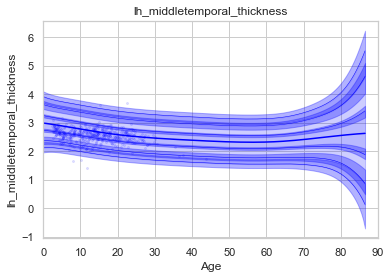

Running IDP 14 lh_parahippocampal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.34737147]), 'Rho': array([-0.00420596]), 'pRho': array([0.91814767]), 'SMSE': array([1.05119191]), 'EXPV': array([-0.03859098])}


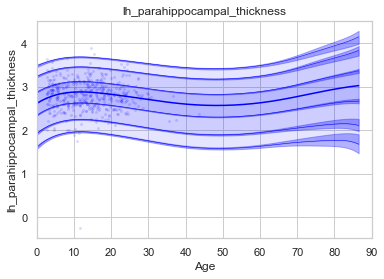

Running IDP 15 lh_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20300796]), 'Rho': array([0.4119471]), 'pRho': array([1.00918273e-26]), 'SMSE': array([0.87314194]), 'EXPV': array([0.16653754])}


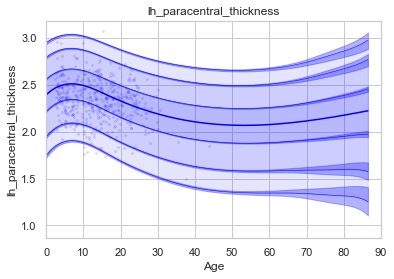

Running IDP 16 lh_parsopercularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20175926]), 'Rho': array([0.30112514]), 'pRho': array([3.12837477e-14]), 'SMSE': array([1.04774852]), 'EXPV': array([0.08181781])}


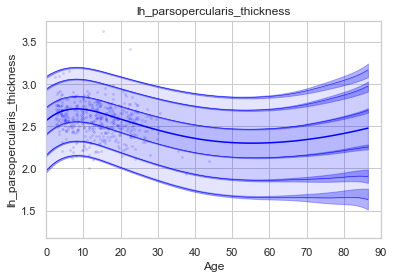

Running IDP 17 lh_parsorbitalis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.30535893]), 'Rho': array([0.41423683]), 'pRho': array([4.86186391e-27]), 'SMSE': array([0.92516613]), 'EXPV': array([0.1637458])}


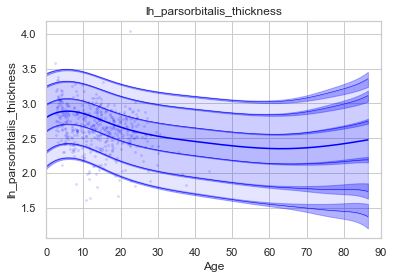

Running IDP 18 lh_parstriangularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20642184]), 'Rho': array([0.4647144]), 'pRho': array([9.32970711e-35]), 'SMSE': array([0.84714557]), 'EXPV': array([0.21366632])}


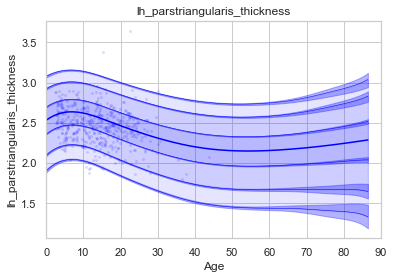

Running IDP 19 lh_pericalcarine_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.2360764]), 'Rho': array([0.31272426]), 'pRho': array([2.66256226e-15]), 'SMSE': array([1.09907566]), 'EXPV': array([0.07559433])}


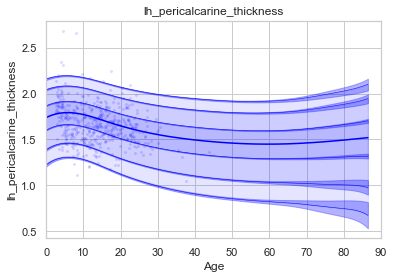

Running IDP 20 lh_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17521784]), 'Rho': array([0.41665931]), 'pRho': array([2.23004751e-27]), 'SMSE': array([0.95736823]), 'EXPV': array([0.15683544])}


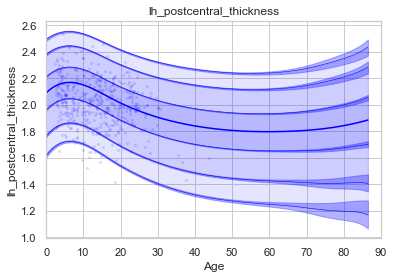

Running IDP 21 lh_posteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21936761]), 'Rho': array([0.37291099]), 'pRho': array([1.03768279e-21]), 'SMSE': array([1.10212673]), 'EXPV': array([-0.06168524])}


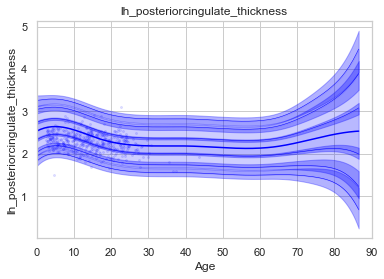

Running IDP 22 lh_precentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16496063]), 'Rho': array([0.10018886]), 'pRho': array([0.01404098]), 'SMSE': array([1.04381726]), 'EXPV': array([-0.03999835])}


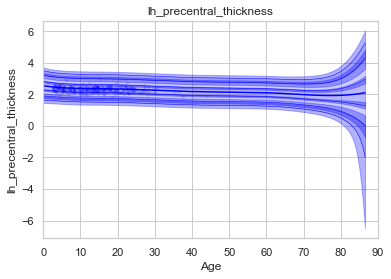

Running IDP 23 lh_precuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15761057]), 'Rho': array([0.67978202]), 'pRho': array([3.67544202e-91]), 'SMSE': array([0.56754058]), 'EXPV': array([0.43871357])}


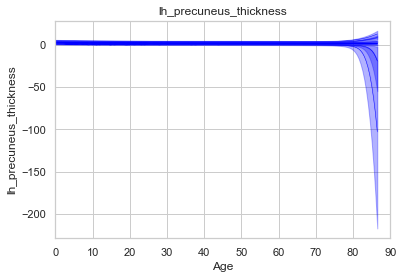

Running IDP 24 lh_rostralanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.29371196]), 'Rho': array([0.4431988]), 'pRho': array([2.72364493e-31]), 'SMSE': array([0.81898224]), 'EXPV': array([0.19606823])}


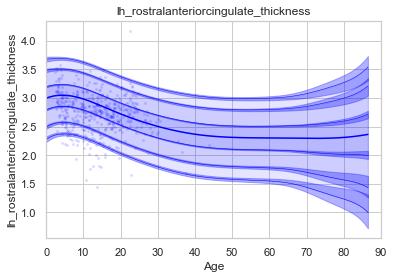

Running IDP 25 lh_rostralmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17518029]), 'Rho': array([0.6296584]), 'pRho': array([3.09439266e-73]), 'SMSE': array([0.61524669]), 'EXPV': array([0.38482175])}


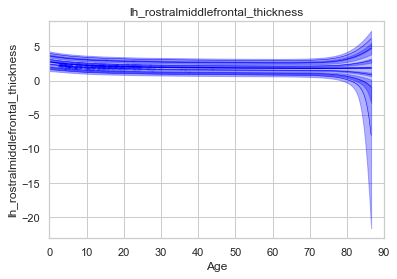

Running IDP 26 lh_superiorfrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18660478]), 'Rho': array([0.62509071]), 'pRho': array([8.60003594e-72]), 'SMSE': array([0.61535608]), 'EXPV': array([0.38993548])}


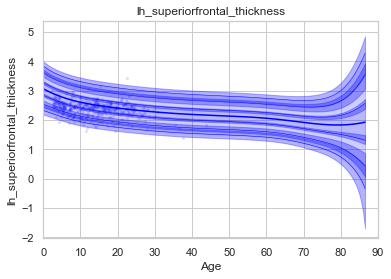

Running IDP 27 lh_superiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17951904]), 'Rho': array([0.56506703]), 'pRho': array([3.67913327e-55]), 'SMSE': array([0.77446058]), 'EXPV': array([0.31379574])}


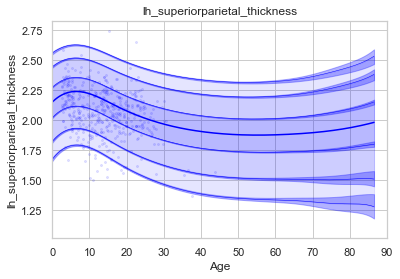

Running IDP 28 lh_superiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21205949]), 'Rho': array([0.36732261]), 'pRho': array([4.73711984e-21]), 'SMSE': array([0.93082823]), 'EXPV': array([0.06969076])}


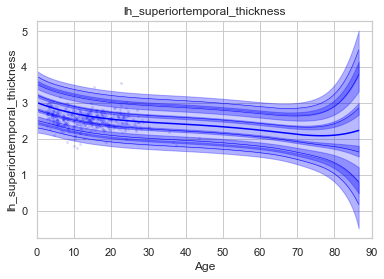

Running IDP 29 lh_supramarginal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18469585]), 'Rho': array([0.59581242]), 'pRho': array([3.6063155e-63]), 'SMSE': array([0.67887654]), 'EXPV': array([0.34425649])}


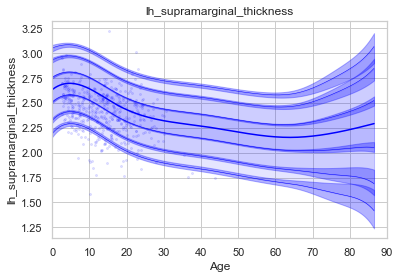

Running IDP 30 lh_frontalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.44253078]), 'Rho': array([0.33804294]), 'pRho': array([8.13142019e-18]), 'SMSE': array([1.00239871]), 'EXPV': array([0.11400378])}


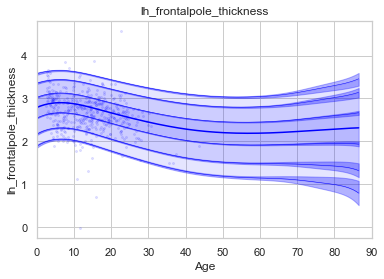

Running IDP 31 lh_temporalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.41958416]), 'Rho': array([-0.0291925]), 'pRho': array([0.47554878]), 'SMSE': array([1.20712363]), 'EXPV': array([-0.08395238])}


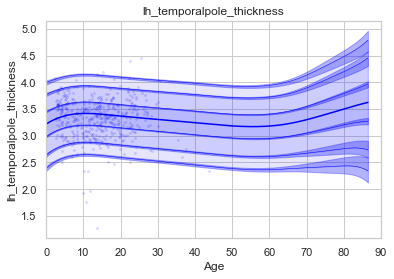

Running IDP 32 lh_transversetemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.29394798]), 'Rho': array([0.42614796]), 'pRho': array([9.83927591e-29]), 'SMSE': array([0.91827911]), 'EXPV': array([0.17786018])}


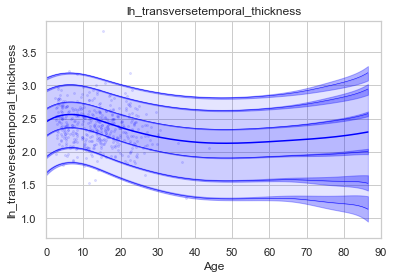

Running IDP 33 lh_insula_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.24691335]), 'Rho': array([0.36875681]), 'pRho': array([3.21809431e-21]), 'SMSE': array([1.03558718]), 'EXPV': array([0.1317585])}


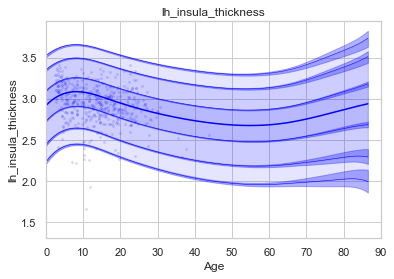

Running IDP 34 rh_bankssts_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23753836]), 'Rho': array([0.43088691]), 'pRho': array([1.98655669e-29]), 'SMSE': array([0.85027102]), 'EXPV': array([0.15167075])}


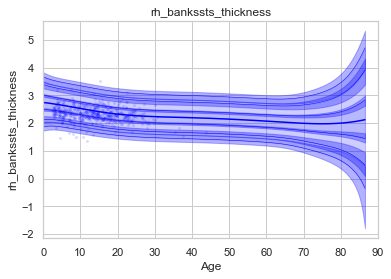

Running IDP 35 rh_caudalanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.32313793]), 'Rho': array([0.23149834]), 'pRho': array([8.37377154e-09]), 'SMSE': array([0.98961493]), 'EXPV': array([0.04528517])}


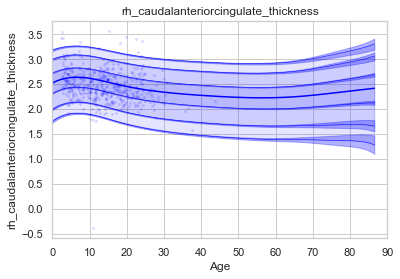

Running IDP 36 rh_caudalmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1962124]), 'Rho': array([0.35860308]), 'pRho': array([4.75297825e-20]), 'SMSE': array([0.8831807]), 'EXPV': array([0.12765064])}


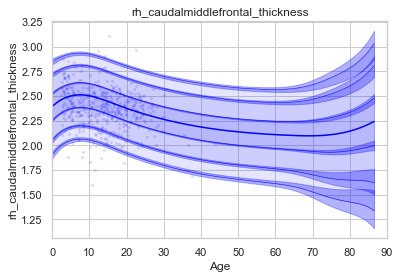

Running IDP 37 rh_cuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21378811]), 'Rho': array([0.50242941]), 'pRho': array([1.54704239e-41]), 'SMSE': array([0.87612777]), 'EXPV': array([0.25219266])}


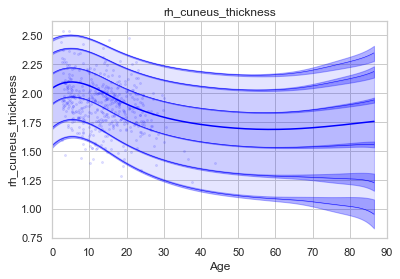

Running IDP 38 rh_entorhinal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.45941217]), 'Rho': array([0.02655208]), 'pRho': array([0.51639325]), 'SMSE': array([1.19811843]), 'EXPV': array([-0.05815393])}


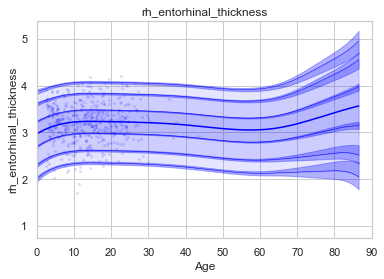

Running IDP 39 rh_fusiform_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19611516]), 'Rho': array([0.38788305]), 'pRho': array([1.51161004e-23]), 'SMSE': array([1.02295688]), 'EXPV': array([-0.01800293])}


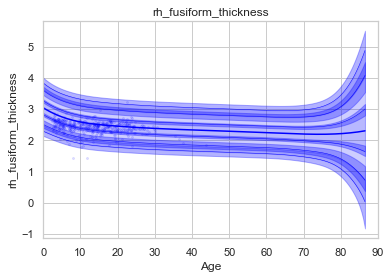

Running IDP 40 rh_inferiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21003513]), 'Rho': array([0.56261116]), 'pRho': array([1.45942215e-54]), 'SMSE': array([0.88321341]), 'EXPV': array([0.15762321])}


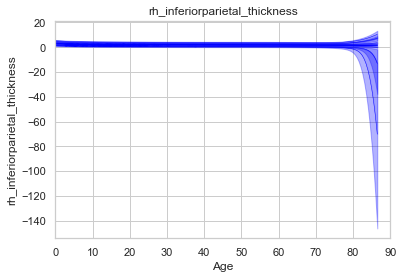

Running IDP 41 rh_inferiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19285458]), 'Rho': array([0.57915367]), 'pRho': array([1.04380561e-58]), 'SMSE': array([0.72186042]), 'EXPV': array([0.2892776])}


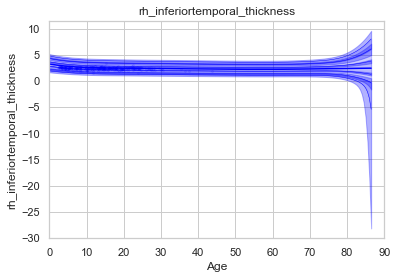

Running IDP 42 rh_isthmuscingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23615675]), 'Rho': array([0.16295246]), 'pRho': array([5.88622664e-05]), 'SMSE': array([1.09830932]), 'EXPV': array([-0.04136772])}


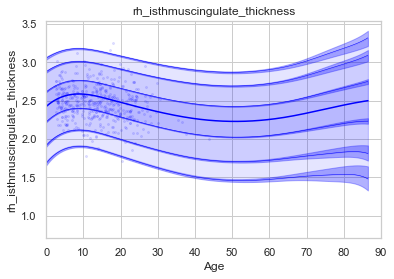

Running IDP 43 rh_lateraloccipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20507265]), 'Rho': array([0.35491177]), 'pRho': array([1.23312154e-19]), 'SMSE': array([0.99248548]), 'EXPV': array([0.09628782])}


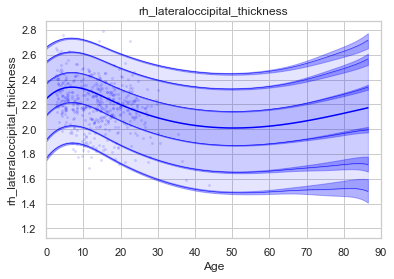

Running IDP 44 rh_lateralorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.2055149]), 'Rho': array([0.73711756]), 'pRho': array([9.55601487e-118]), 'SMSE': array([0.46723052]), 'EXPV': array([0.5404807])}


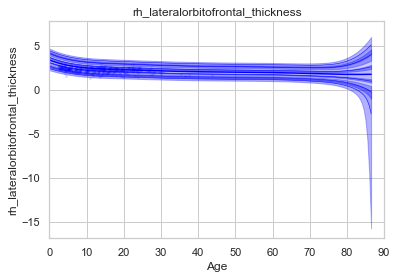

Running IDP 45 rh_lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19171802]), 'Rho': array([0.49370167]), 'pRho': array([6.98305721e-40]), 'SMSE': array([0.91490319]), 'EXPV': array([0.24366262])}


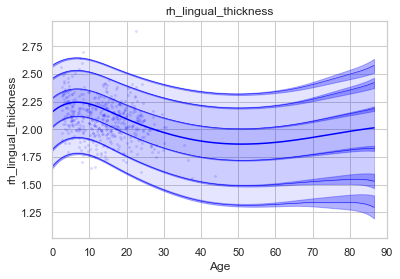

Running IDP 46 rh_medialorbitofrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23194224]), 'Rho': array([0.74336243]), 'pRho': array([3.69316251e-121]), 'SMSE': array([0.46266914]), 'EXPV': array([0.55117553])}


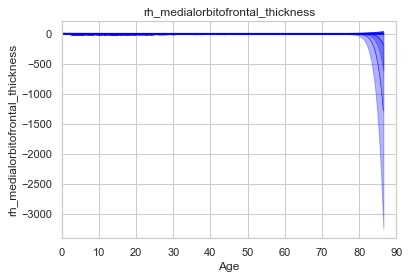

Running IDP 47 rh_middletemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21186336]), 'Rho': array([0.50770413]), 'pRho': array([1.45572873e-42]), 'SMSE': array([0.79980944]), 'EXPV': array([0.24533601])}


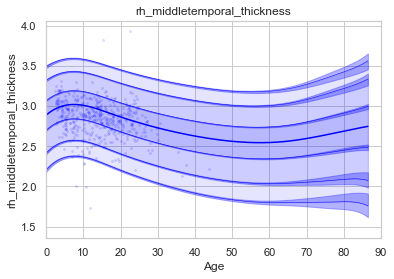

Running IDP 48 rh_parahippocampal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.31375275]), 'Rho': array([0.11245325]), 'pRho': array([0.00579242]), 'SMSE': array([1.08682665]), 'EXPV': array([-0.01396865])}


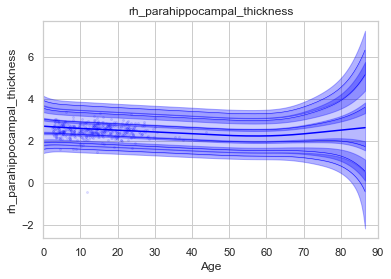

Running IDP 49 rh_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20540571]), 'Rho': array([0.29434378]), 'pRho': array([1.25271485e-13]), 'SMSE': array([1.04660339]), 'EXPV': array([0.01940683])}


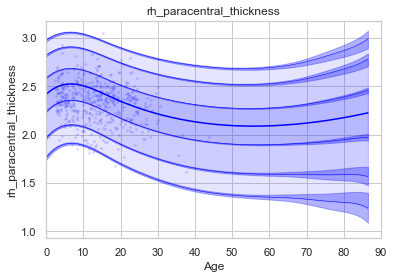

Running IDP 50 rh_parsopercularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18653347]), 'Rho': array([0.57034847]), 'pRho': array([1.8155148e-56]), 'SMSE': array([0.7323233]), 'EXPV': array([0.31241645])}


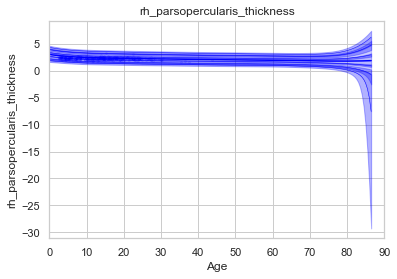

Running IDP 51 rh_parsorbitalis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.30686573]), 'Rho': array([0.46312517]), 'pRho': array([1.7191972e-34]), 'SMSE': array([0.8692165]), 'EXPV': array([0.20985295])}


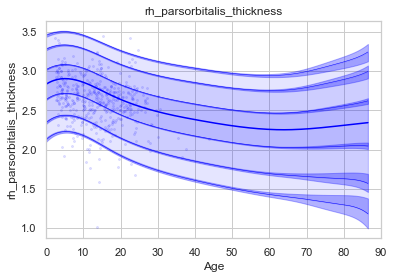

Running IDP 52 rh_parstriangularis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19548011]), 'Rho': array([0.64579244]), 'pRho': array([1.42890896e-78]), 'SMSE': array([0.59417507]), 'EXPV': array([0.40640884])}


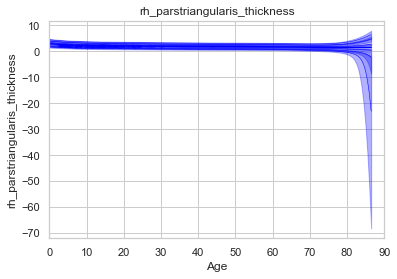

Running IDP 53 rh_pericalcarine_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23552984]), 'Rho': array([0.26724716]), 'pRho': array([2.19715978e-11]), 'SMSE': array([1.12985359]), 'EXPV': array([0.0561004])}


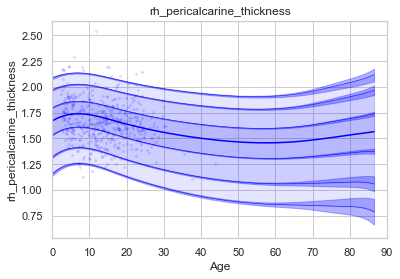

Running IDP 54 rh_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17193056]), 'Rho': array([0.4722523]), 'pRho': array([4.89058073e-36]), 'SMSE': array([0.85759956]), 'EXPV': array([0.22178838])}


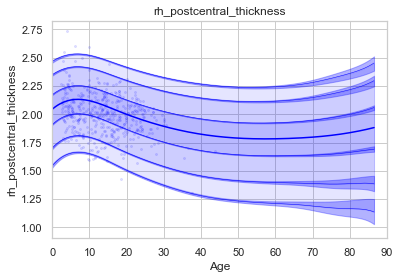

Running IDP 55 rh_posteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21034314]), 'Rho': array([0.47784183]), 'pRho': array([5.20653531e-37]), 'SMSE': array([1.02019927]), 'EXPV': array([0.13743893])}


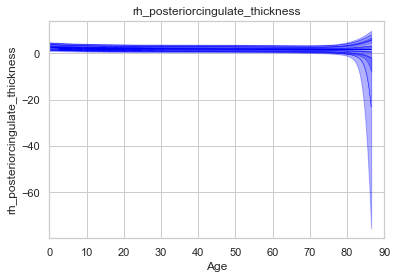

Running IDP 56 rh_precentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18591596]), 'Rho': array([0.03987823]), 'pRho': array([0.32961731]), 'SMSE': array([1.24888524]), 'EXPV': array([-0.12727883])}


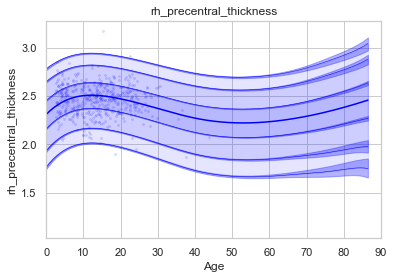

Running IDP 57 rh_precuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18417831]), 'Rho': array([0.58214655]), 'pRho': array([1.73382368e-59]), 'SMSE': array([0.91388358]), 'EXPV': array([0.14983344])}


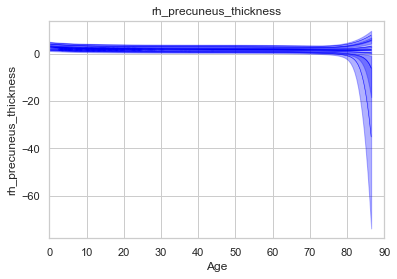

Running IDP 58 rh_rostralanteriorcingulate_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.37497012]), 'Rho': array([0.36250164]), 'pRho': array([1.71122873e-20]), 'SMSE': array([0.97503562]), 'EXPV': array([0.13057462])}


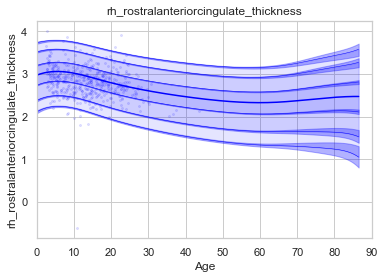

Running IDP 59 rh_rostralmiddlefrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18333351]), 'Rho': array([0.74770912]), 'pRho': array([1.31818659e-123]), 'SMSE': array([0.48510148]), 'EXPV': array([0.55904043])}


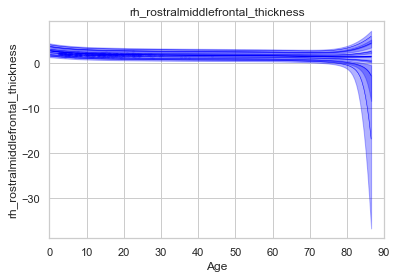

Running IDP 60 rh_superiorfrontal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19759129]), 'Rho': array([0.64107761]), 'pRho': array([5.66754975e-77]), 'SMSE': array([0.61894042]), 'EXPV': array([0.41096543])}


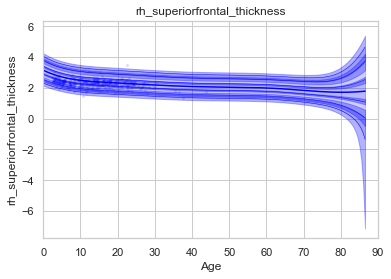

Running IDP 61 rh_superiorparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17594917]), 'Rho': array([0.50807535]), 'pRho': array([1.23048478e-42]), 'SMSE': array([0.81609921]), 'EXPV': array([0.25687956])}


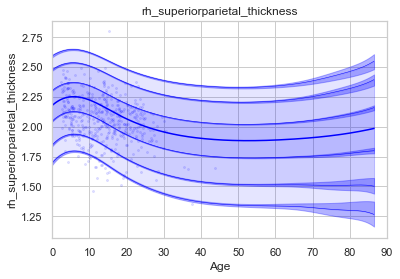

Running IDP 62 rh_superiortemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21308662]), 'Rho': array([0.42356212]), 'pRho': array([2.32827414e-28]), 'SMSE': array([0.91234334]), 'EXPV': array([0.09877187])}


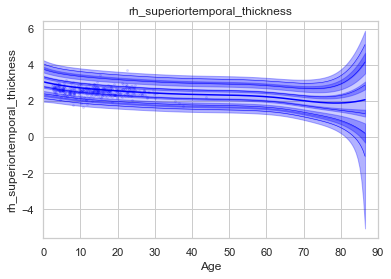

Running IDP 63 rh_supramarginal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19972693]), 'Rho': array([0.61742881]), 'pRho': array([1.9688712e-69]), 'SMSE': array([0.84377399]), 'EXPV': array([0.17776532])}


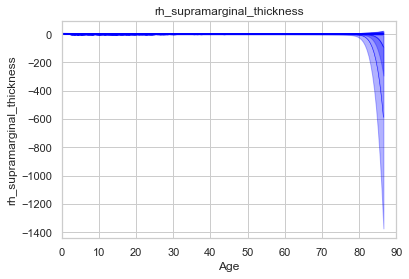

Running IDP 64 rh_frontalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.39170534]), 'Rho': array([0.47237038]), 'pRho': array([4.66676783e-36]), 'SMSE': array([0.84189212]), 'EXPV': array([0.22115729])}


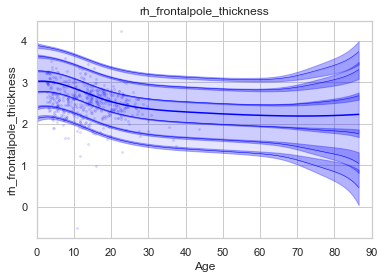

Running IDP 65 rh_temporalpole_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.47450744]), 'Rho': array([-0.08288221]), 'pRho': array([0.04238035]), 'SMSE': array([1.55364973]), 'EXPV': array([-0.26815749])}


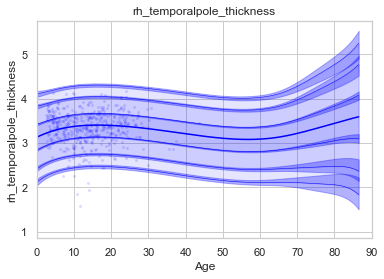

Running IDP 66 rh_transversetemporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.30231495]), 'Rho': array([0.36455388]), 'pRho': array([9.93360803e-21]), 'SMSE': array([1.02037324]), 'EXPV': array([0.1318706])}


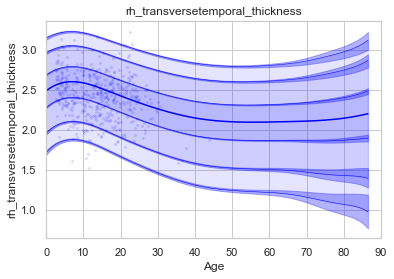

Running IDP 67 rh_insula_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21806154]), 'Rho': array([0.44844972]), 'pRho': array([4.11702674e-32]), 'SMSE': array([0.91409859]), 'EXPV': array([0.19203719])}


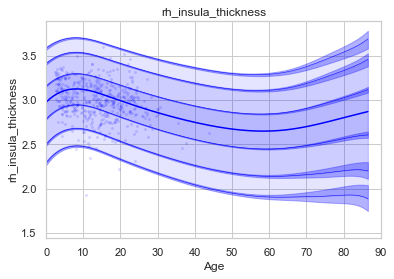

In [46]:
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    
    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
            
    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')
    
    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))
    
    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    
    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)
    
    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points 
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set
            
            # first, we select the data points belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue
            
            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset 
            
            # first, select the data point belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, (df_te['site'] == site).to_numpy()))[0]
            
            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] == sex, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue
            
            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_te[idx]))
        # plot the (adjusted) data points
        plt.scatter(X_te[idx,1], y_te_rescaled, s=4, color=clr, alpha = 0.1)
       
    # plot the median of the dummy data
    plt.plot(xx, med, clr)
    
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
            
    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
    plt.xlim((0,90))
    plt.savefig(os.path.join(idp_dir, 'centiles_' + str(sex)),  bbox_inches='tight')
    plt.show()

os.chdir(out_dir)

In [461]:
pd.DataFrame(metrics.mean(axis = 0))

,0
0,0.374921


# CLUSTERING

### Importe package, définit des fonctions utiles

In [47]:
from matplotlib import pyplot
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [48]:
# Fonction pour extraire les caractéristiques de chaque cluster dans un tableau
def comp_cluster(clustered_data):
    mean_age = {}
       
    
    for i in list(set(clustered_data['Cluster'])):
        n = clustered_data.loc[clustered_data['Cluster'] == i].shape[0]
        mean_age.update({i : [clustered_data.loc[clustered_data['Cluster'] == i]['age_at_first_scan'].mean(),
                              int(n), 
                              (n/clustered_data.shape[0])*100,
                                clustered_data.loc[clustered_data['Cluster'] == i]['mean_Z'].mean()]})
    
    rownames = ['Age mean', 'N', '% N', 'Mean CT']

    return pd.DataFrame(mean_age, index = rownames )

### Extrait les Z-scores

In [51]:
# Extraction des Z-Scores dans les fichiers outputs en Dataframe
Z_pred = {}

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    f = open("Z_predict.txt", "r")
    Z_pred.update({f'{idp}_Z_predict' : f.readlines()})
    
Z_df_pred = pd.DataFrame(Z_pred).astype(float)
Z_df_pred

if (pred_bool == '1'):
    # Si on a TD + ASD dans dataset pour prédiction : garde les Z-scores que des ASD
    Z_df_pred = Z_df_pred.loc[df_te2['ASD'] == 'Yes']


# Ajoute une colonne de Z-Scores moyens 
cols_df = [col for col in Z_df_pred.columns if 'predict' in col]
#Enlève outliers
Z_df_pred = Z_df_pred.drop(Z_df_pred.loc[Z_df_pred[cols_df].mean(axis = 1) > 3].index)

# Récupère info liées aux individus 
Z_df_pred = Z_df_pred.join(df_te2.reset_index())



Z_df_pred['mean_Z'] = Z_df_pred[cols_df].mean(axis = 1)





### // Si on clean NA dans les scores avant le clustering...

In [ ]:
# Retire tous les individus comportant au moins 1 NA dans les scores
Z_df_pred[Scores] = Z_df_pred[Scores].replace({999 : np.nan, 777 : np.nan})
Z_df_pred = Z_df_pred.dropna(subset = Scores)

### Déterminer le nombre optimal de clusters

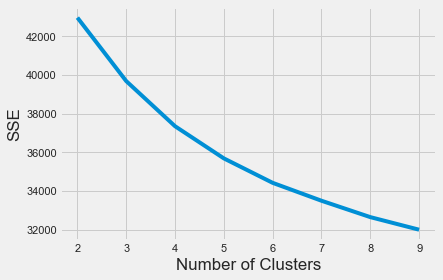

In [52]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 1000,
"random_state": 42,
}
# A list holds the SSE values for each k
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(Z_df_pred[cols_df])
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), sse)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [53]:
# Renseigner nombre de cluster final : coude du SSE
n_clusters = 5

## Gaussian Mixture Model

In [147]:
boot_clus = int(input('Nombre de bootstraps pour le clustering : '))

Nombre de bootstraps pour le clustering : 100


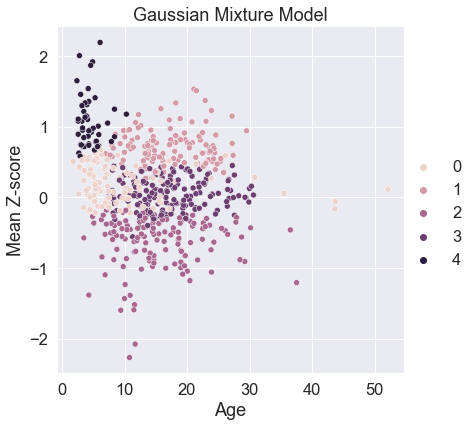

In [192]:
super_clus = []
for i in range(boot_clus):
    model = GaussianMixture(n_components=n_clusters).fit(Z_df_pred[cols_df])
    gm_labels = model.predict(Z_df_pred[cols_df])
    GMM_df = Z_df_pred.assign(Cluster = gm_labels)
    df_cluster = comp_cluster(GMM_df)

    super_clus.append(df_cluster.T.sort_values(by = ['N']).reset_index())
sns.set_theme(style="darkgrid",font_scale=1.5)
c = sns.relplot(data=Z_df_pred, x="age_at_first_scan", y='mean_Z', hue=gm_labels, height=6).set(xlabel = 'Age', ylabel = "Mean Z-score", title = 'Gaussian Mixture Model')
plt.show()

### Filtrer les clusters

In [193]:
n_min = int(input("Définir un nombre min d'individus par cluster : "))
print('Tout modèle comportant au moins un cluster avec <', n_min, 'individus sera enlevé')

Définir un nombre min d'individus par cluster : 30
Tout modèle comportant au moins un cluster avec < 30 individus sera enlevé


In [194]:
filtered_clus = super_clus.copy()
len(filtered_clus)

100

In [196]:
filtered_clus = super_clus.copy()
l_pop = []
for c in range(boot_clus):
    for i in filtered_clus[c]['N']:
        if (i < n_min): 
            l_pop.append(c)
print(l_pop)


    
dfs = pd.concat(filtered_clus, axis =1)
pd.DataFrame({'Age mean' : dfs['Age mean'].mean(axis = 1), 
              'N' : dfs['N'].mean(axis = 1), 
              '% N' : dfs['% N'].mean(axis = 1),
             'Mean Z-Score' : dfs['Mean CT'].mean(axis =1)})

[0, 1, 12, 40, 55, 73, 95]


,Age mean,N,% N,Mean Z-Score
0,12.314413,64.63,10.807692,-0.453544
1,7.695314,89.81,15.018395,0.374528
2,15.733008,125.96,21.063545,0.399810
3,16.284477,140.76,23.538462,0.346822
4,15.348159,176.84,29.571906,-0.068820


In [ ]:
f = filtered_clus.iloc

# CORRELATION SPEARMAN

In [779]:
from scipy import stats

In [780]:
# Définir les scores à corréler avec Z-Scores moyens
Scores =  ['t1_adi_social_total','t1_adi_communication_total', 't1_adi_rrb_total',
           't1_css_total_all', 't1_sa_css_all', 't1_rrb_css_all',
          't1_srs_tscore', 't1_srs_tscore_self',
         
          't1_rbs_total',
          't1_ssp_total',
         't1_adhd_inattentiv_parent', 't1_adhd_hyperimpul_parent']

In [785]:
# Fonction pour enlever les NA
def clean_NA(GMM_df):
    for i in GMM_df[Scores]:
        GMM_df[i] = GMM_df[i].replace({999 : np.nan,777: np.nan})

        df_corr = GMM_df[Scores].dropna().join(GMM_df['Cluster']).join(GMM_df[cols_df])
    
    return df_corr

In [786]:
clean_df = clean_NA(GMM_df)

In [792]:
# Fonction calculant la corrélation de Spearman entre Z-Scores moyen et les Scores, par cluster
# Bar plot: bleu = non signiticatif; rouge = significatif

def compute_spearman(GMM_df):
    
    
    spearman_df = {}
    pval_df = {}
    double_df = {}
    for cluster in set(GMM_df['Cluster']):
        l = []
        pval = []
        d = []
        for score in Scores:
            temp_s = stats.spearmanr(GMM_df[score].loc[GMM_df['Cluster'] == cluster], 
                            GMM_df[cols_df].loc[GMM_df['Cluster'] == cluster].mean(axis =1 )).correlation
            temp_p = stats.spearmanr(GMM_df[score].loc[GMM_df['Cluster'] == cluster], 
                            GMM_df[cols_df].loc[GMM_df['Cluster'] == cluster].mean(axis =1 )).pvalue
            l.append(temp_s)
            pval.append(temp_p)
            d.append([temp_s, temp_p])
            double_df.update({cluster : d})
            spearman_df.update({cluster : l})
            pval_df.update({cluster : pval})

    spearman_df = pd.DataFrame.from_dict(spearman_df)
    spearman_df.index = Scores
    pval_df = pd.DataFrame.from_dict(pval_df)
    pval_df.index = Scores
    double_df = pd.DataFrame.from_dict(double_df)
    double_df.index = Scores
    

    for c in range(n_clusters):
        l_sig = []
        n=GMM_df.loc[GMM_df['Cluster'] == c].shape[0]
        if (n != 0):
            for idx,i in enumerate(double_df[c]):

                if i[1] < 0.05:

                    l_sig.append(idx)

            l_col = []
            for k in range(len(Scores)):
                if k in l_sig:
                    l_col.append('red')
                else:
                    l_col.append('blue')


            fig = plt.figure(figsize = (10, 5))

            # creating the bar plot
            y_pos = range(len(double_df.index))
            barlist = plt.bar(y_pos,spearman_df[c], color = l_col,
                width = 0.4)


            plt.ylim(-0.8, 0.8)
            plt.xticks(y_pos, Scores, rotation = 90)
            plt.title("Correlation Mean Z w/ Scores")
            print('N = ', n)
            plt.show()



    return spearman_df, pval_df, double_df



N =  12


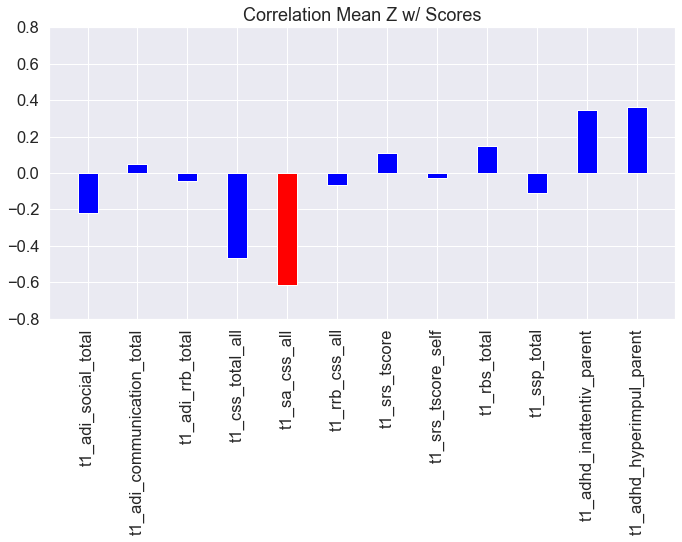

N =  12


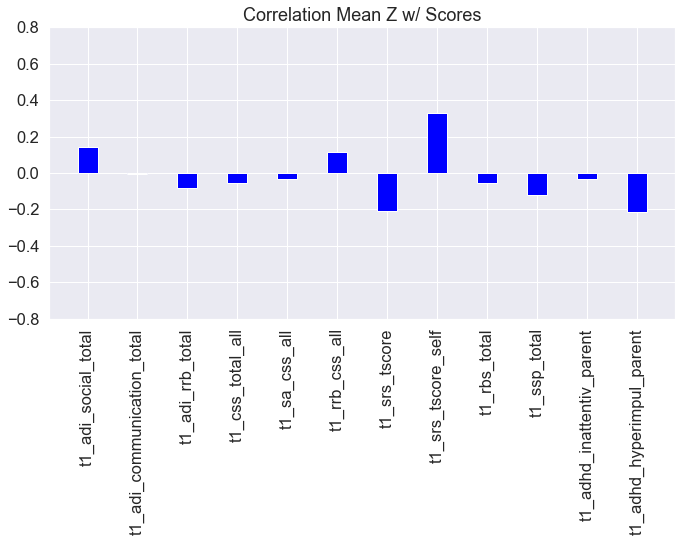

N =  20


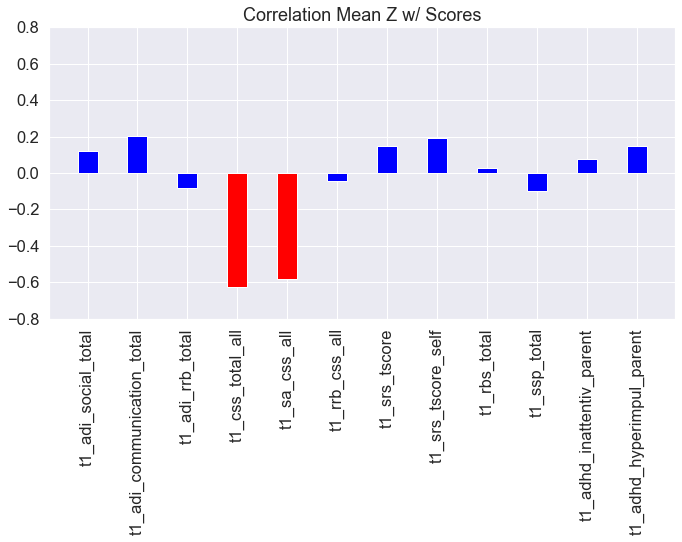

N =  20


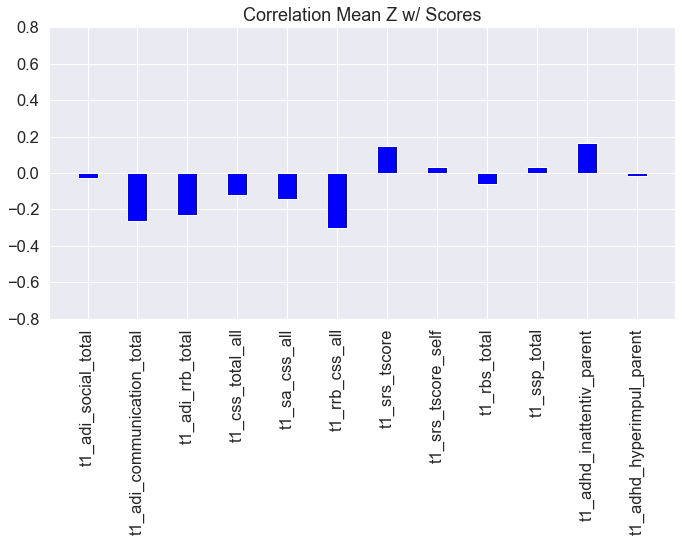

N =  16


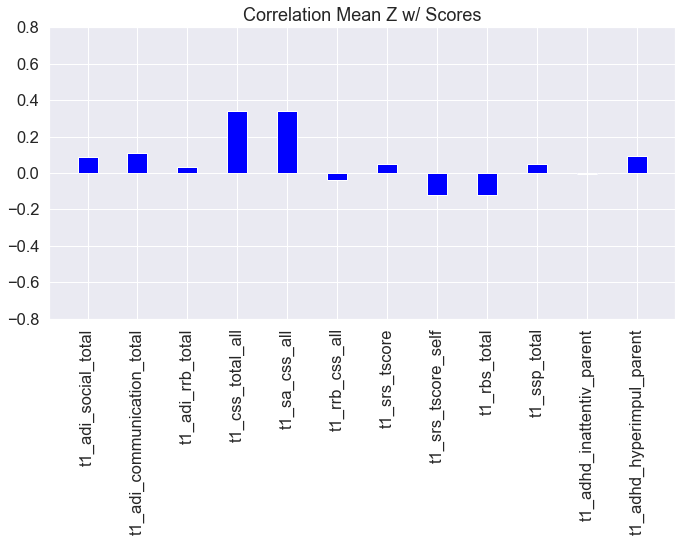

In [788]:
spearman_df, pval_df, double_df = compute_spearman(clean_df)

# COURBE ROC 

In [462]:
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

## EXTRAIT LES Z-SCORES

In [463]:
Z_pred = {}

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    f = open("Z_predict.txt", "r")
    Z_pred.update({f'{idp}_Z_predict' : f.readlines()})
    
Z_df_pred = pd.DataFrame(Z_pred).astype(float)
Z_df_pred

,lh_bankssts_thickness_Z_predict,lh_caudalanteriorcingulate_thickness_Z_predict,lh_caudalmiddlefrontal_thickness_Z_predict,lh_cuneus_thickness_Z_predict,lh_entorhinal_thickness_Z_predict,lh_fusiform_thickness_Z_predict,lh_inferiorparietal_thickness_Z_predict,lh_inferiortemporal_thickness_Z_predict,lh_isthmuscingulate_thickness_Z_predict,lh_lateraloccipital_thickness_Z_predict,...,rh_rostralanteriorcingulate_thickness_Z_predict,rh_rostralmiddlefrontal_thickness_Z_predict,rh_superiorfrontal_thickness_Z_predict,rh_superiorparietal_thickness_Z_predict,rh_superiortemporal_thickness_Z_predict,rh_supramarginal_thickness_Z_predict,rh_frontalpole_thickness_Z_predict,rh_temporalpole_thickness_Z_predict,rh_transversetemporal_thickness_Z_predict,rh_insula_thickness_Z_predict
0,-3.164631,-0.307386,-0.408798,-1.848981,-1.371236,-2.483146,-1.211789,-0.588192,-0.609683,-1.672385,...,-0.947251,-3.019555,-2.032532,-2.341584,-0.356514,-2.144855,-3.020212,-0.581983,-0.386106,-0.855168
1,-1.555182,-1.139212,-0.380976,-0.089449,-0.633275,-2.343425,-0.195872,-0.416150,-0.126414,-1.999651,...,-0.077726,-0.634295,-0.713567,-1.372256,-0.543517,-1.885453,-1.043099,-0.246492,-0.809076,0.047744
2,-0.438795,0.843053,0.194896,-1.257832,0.658279,-0.681958,0.023251,0.955005,0.023370,-1.425445,...,-0.260013,-0.729562,-0.352227,-1.139953,0.985736,-0.927101,0.449183,1.291545,0.324569,-0.123441
3,-0.714736,-0.244237,-1.015022,-1.596187,-1.713883,-1.092002,-0.942363,-0.921840,-0.630626,0.215227,...,-0.954513,-1.727203,-1.510290,-2.008169,-0.687815,-1.375058,-0.017848,-1.042548,-0.324885,-0.586114
4,1.295925,0.697100,-1.641714,-1.023662,-1.647750,-0.501953,0.160818,-1.056057,1.473265,-0.455669,...,1.995337,-0.182472,-1.637389,-0.177066,-0.590947,0.602105,-1.255009,0.462811,0.934310,0.327748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0.230782,0.266001,0.920608,0.314041,-1.799088,-0.614239,-0.317920,-0.434989,-0.810999,-0.516866,...,-0.462194,-0.407918,-0.832681,-0.151447,0.356309,0.764325,-0.499689,-0.705155,0.850725,-0.479496
805,0.433538,-0.132754,1.892300,0.324773,-1.310497,-0.240188,-0.111400,-0.435096,-0.924435,-0.360700,...,0.710930,1.116683,1.843520,0.704955,0.536935,1.527803,0.192223,0.259266,0.626669,-0.685520
806,-1.015466,-0.456213,-1.504310,0.659835,0.302387,0.315216,-0.428719,-0.452271,-0.287452,-0.597436,...,-0.611794,0.132254,-0.447699,-0.235205,-0.094734,-0.194193,-1.414476,1.084414,-1.049545,0.221689
807,1.825753,0.455777,-0.754401,0.525351,-0.556924,0.812053,0.570407,-0.104163,0.272819,0.638355,...,-0.240127,-0.365937,-0.394102,-0.520740,0.521964,-0.144054,-0.106496,0.776324,-0.615943,1.050225


In [464]:
X1 = Z_df_pred.to_numpy()

In [465]:
Z_df_pred['t1_diagnosis'] = Z_df_pred.index

In [466]:
y = Z_df_pred['t1_diagnosis'].astype(int).to_numpy()

In [467]:
random_state = np.random.RandomState(0)
n_samples, n_features = X1.shape

ValueError: n_splits=5 cannot be greater than the number of members in each class.

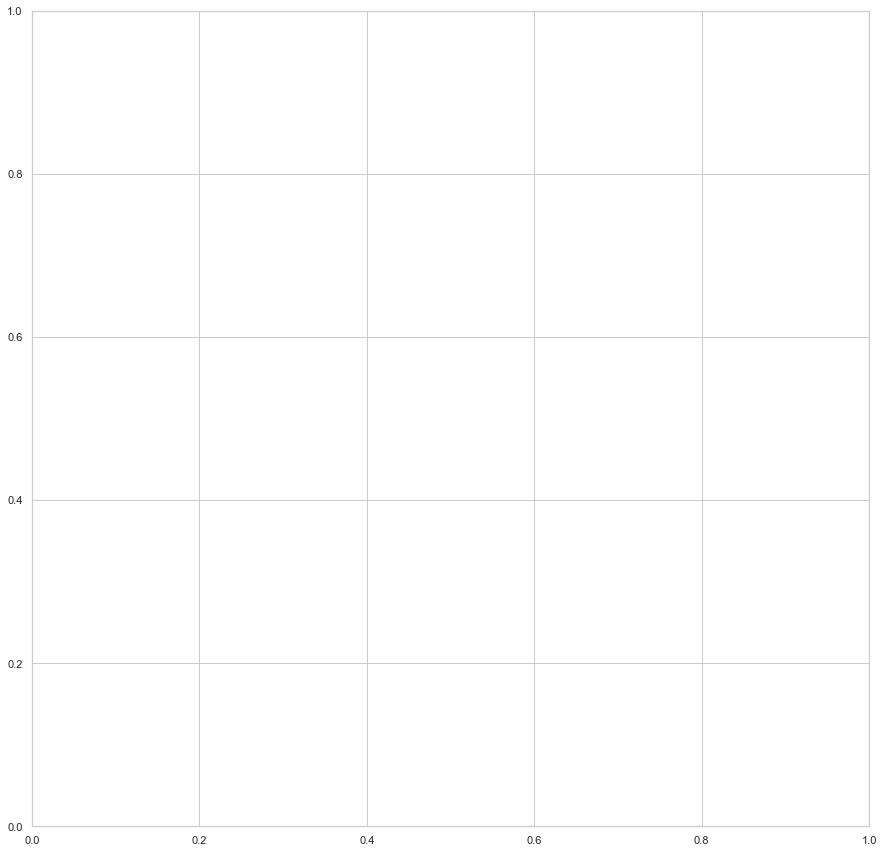

In [468]:
cv = StratifiedKFold(n_splits=5)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(15,15))
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25, 'xtick.labelsize':16,'ytick.labelsize':16,'legend.fontsize':14,'legend.title_fontsize':16}
plt.rcParams.update(parameters)

for i, (train, test) in enumerate(cv.split(X1, y)):
    classifier.fit(X1[train], y[train])
    viz = plot_roc_curve(classifier, X1[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_title('Receiver operating characteristic SZ vs. HC (deviations)', fontweight="bold", size=20)
ax.legend(loc="lower right")
plt.show()

# PREPARATION DES Z-SCORES

## Z-scores prédits

# TEST STATISTIQUES

In [564]:
14

(14, 0, 394)

TypeError: can't multiply sequence by non-int of type 'tuple'

In [830]:
Z_pred = {}

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    f = open("Z_predict.txt", "r")
    Z_pred.update({f'{idp}_Z_predict' : f.readlines()})
    
Z_df_pred = pd.DataFrame(Z_pred).astype(float)
Z_df_pred

,lh_bankssts_thickness_Z_predict,lh_caudalanteriorcingulate_thickness_Z_predict,lh_caudalmiddlefrontal_thickness_Z_predict,lh_cuneus_thickness_Z_predict,lh_entorhinal_thickness_Z_predict,lh_fusiform_thickness_Z_predict,lh_inferiorparietal_thickness_Z_predict,lh_inferiortemporal_thickness_Z_predict,lh_isthmuscingulate_thickness_Z_predict,lh_lateraloccipital_thickness_Z_predict,...,rh_rostralanteriorcingulate_thickness_Z_predict,rh_rostralmiddlefrontal_thickness_Z_predict,rh_superiorfrontal_thickness_Z_predict,rh_superiorparietal_thickness_Z_predict,rh_superiortemporal_thickness_Z_predict,rh_supramarginal_thickness_Z_predict,rh_frontalpole_thickness_Z_predict,rh_temporalpole_thickness_Z_predict,rh_transversetemporal_thickness_Z_predict,rh_insula_thickness_Z_predict
0,2.133136,0.835820,3.675486,1.524130,-0.930469,2.540606,0.848083,1.648378,0.443183,2.168208,...,1.503359,1.040856,4.477558,2.893069,0.705335,1.230084,2.929522,-1.275094,1.806240,2.175037
1,-0.238953,-1.365764,0.409226,-0.086509,-0.099241,0.561208,-0.021821,0.491102,-0.517409,-0.698565,...,-0.743571,0.698609,0.181058,0.351983,0.808343,1.074635,-1.168760,1.416089,1.291228,-0.557876
2,1.787576,2.729032,-0.651406,1.119110,-0.138756,0.627489,0.532242,0.651230,1.270977,-0.843811,...,0.790346,-0.562497,0.222631,2.522079,0.628149,-0.484649,0.526727,0.584335,0.436659,1.238009
3,1.003530,1.791509,0.661791,0.372448,0.312457,2.106470,0.158076,1.320967,0.923727,0.197477,...,2.487112,-0.385369,0.906456,0.701729,0.409445,0.351184,2.556293,0.346503,1.052114,1.739443
4,1.717501,1.270085,-0.168719,-0.389901,0.631422,2.320296,1.016131,1.529591,0.217809,-0.380314,...,1.968662,-0.251543,-0.499484,0.771867,0.181865,-0.003813,-0.758031,0.494178,-0.021143,0.837836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,-3.037763,-1.611101,-1.386277,-0.556301,0.243238,-0.848148,-1.078739,-0.100498,-0.808837,-1.784476,...,0.543542,0.058575,-0.718734,-2.059969,-1.111585,-2.441181,-1.107653,0.149683,-0.010029,-1.082096
805,0.474101,-0.042670,-1.694794,0.223823,-0.242535,-0.332253,0.127861,-0.205497,-0.073630,-0.723310,...,0.221313,0.361337,-0.142377,-1.914979,0.123717,-0.999913,0.623817,1.143361,-0.621879,1.364518
806,-0.698465,-0.683404,-1.748684,-1.027500,1.302389,-1.014962,-0.947981,-0.132665,-0.018404,-2.722882,...,0.906724,0.085074,-0.291738,-1.731890,-0.783686,-1.675499,0.619878,0.385808,-0.515072,-0.701884
807,1.837203,1.399833,1.361445,-0.304974,-0.087716,0.707749,-0.573143,0.343748,1.333562,-0.167102,...,0.648613,0.685497,1.421508,1.028272,0.399597,0.840216,1.133987,-0.805928,-0.498625,-0.726025


In [554]:
from scipy.stats import ttest_ind
from statsmodels.stats import multitest

In [555]:
Z_df_pred.columns= Z_df_pred.columns.str.replace('_Z_predict','')

## T-Tests sur Z-scores

In [556]:
pvals_z = pd.DataFrame(columns={'roi','pval', 'tstat','fdr_pval'})
for index, column in enumerate(Z_df_pred):
    test = ttest_ind(Z_df_pred.loc[idx_asd][column], Z_df_pred.loc[idx_td][column])
    pvals_z.loc[index, 'pval'] = test.pvalue
    pvals_z.loc[index, 'tstat'] = test.statistic
    pvals_z.loc[index, 'roi'] = column

In [557]:
fdr_z = multitest.fdrcorrection(pvals_z['pval'], alpha=0.05, method='indep', is_sorted=False)

In [558]:
pvals_z['fdr_pval'] = fdr_z[1]

In [559]:
sig_diff = pvals_z.query('pval < 0.05')
sig_diff

,fdr_pval,tstat,pval,roi
1,0.000298,3.911608,0.000099,R_sum


# MAPPING VISUALISATION

## Avec ENIGMA

In [831]:
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical

### Calcul de prévalences des déviations extrêmes

In [833]:
df_te3 = df_te2

In [835]:
idx_asd = list(df_te3.loc[df_te3['ASD'] == 'Yes'].index)
idx_td = list(df_te3.loc[df_te3['ASD'] == 'No'].index)
Z_df_est = Z_df_pred.loc[idx_td]
Z_df_pred = Z_df_pred.loc[idx_asd]

In [837]:
print('Nombre de TD : ', Z_df_est.shape[0])
print('Nombre de ASD : ', Z_df_pred.shape[0])

(209, 68)
(600, 68)


In [838]:
def compute_abs_prevalence(Z_df_est):
    prev_est= {}
    for i in Z_df_est.columns:
        prev_est.update({i : [Z_df_est.query(f'{i} > 2 or {i} < -2').count()[1]/Z_df_est.shape[0]]})
    prev_est = pd.DataFrame.from_dict(prev_est)
    
    return prev_est

In [839]:
def compute_positive_prevalence(Z_df_est):
    prev_est= {}
    for i in Z_df_est.columns:
        prev_est.update({i : [Z_df_est.query(f'{i} > 2').count()[1]/Z_df_est.shape[0]]})
    prev_est = pd.DataFrame.from_dict(prev_est)
    
    return prev_est

In [840]:
pos_prev_TD = compute_positive_prevalence(Z_df_est)

In [841]:
pos_prev_ASD = compute_positive_prevalence(Z_df_pred)

In [842]:
abs_TD = compute_abs_prevalence(Z_df_est)

In [843]:
abs_ASD = compute_abs_prevalence(Z_df_pred)

## Cartographie prévalences

In [844]:
diff_abs = abs_ASD.values - abs_TD.values

In [845]:
print('max : ', diff_abs.max())
print('min : ', diff_abs.min())

max :  0.09054226475279106
min :  -0.05160287081339712


In [846]:
CT_d_fsa5 = parcel_to_surface(diff_abs, 'aparc_fsa5')
plot_cortical(array_name=CT_d_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='RdBu_r', color_bar=True, color_range=(-0.10, 0.10))

### prévalence de Z > 2

In [558]:
diff_pos = pos_prev_ASD.values - pos_prev_TD.values

In [559]:
print('max : ', diff_pos.max())
print('min : ', diff_pos.min())

max :  0.12001001573901844
min :  -0.009264558592073258


In [349]:
CT_d_fsa5 = parcel_to_surface(diff_pos, 'aparc_fsa5')
plot_cortical(array_name=CT_d_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='RdBu_r', color_bar=True, color_range=(-0.07, 0.07))

In [359]:
pos_prev_ASD.T.describe()

,0
count,68.000000
mean,0.023808
std,0.013764
min,0.002427
25%,0.012136
50%,0.024272
75%,0.031553
max,0.065534


## Cartographie Z-scores moyens

In [403]:
Z_df_est.mean(axis = 0).min()

-0.29473082644380977

In [404]:
CT_d_fsa5 = parcel_to_surface(Z_df_est.mean(axis = 0), 'aparc_fsa5')
plot_cortical(array_name=CT_d_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='RdBu_r', color_bar=True, color_range=(-0.4, 0.4))

In [274]:
Z_df_pred.mean(axis = 0).max()

0.22261664268360465

In [275]:
CT_d_fsa5 = parcel_to_surface(Z_df_pred.median(axis = 0), 'aparc_fsa5')
plot_cortical(array_name=CT_d_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='RdBu_r', color_bar=True, color_range=(-0.4, 0.4))

## Cartographie EV

### De l'estimation

In [110]:
print(blr_metrics['EV'].max())
print(blr_metrics['EV'].min())

0.6642217918854881
-0.036931442970250083


In [111]:
CT_d_fsa5 = parcel_to_surface(blr_metrics['EV'], 'aparc_fsa5')
plot_cortical(array_name=CT_d_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='RdBu_r', color_bar=True, color_range=(-0.7, 0.7))

In [636]:
Z_df = Z_df_est

In [124]:
CT_d_fsa5 = parcel_to_surface(metrics['EXPV'], 'aparc_fsa5')
plot_cortical(array_name=CT_d_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='RdBu_r', color_bar=True, color_range=(-0.6, 0.6))

In [78]:
Z_df_pred.median(axis = 0)

L_bankssts_thickavg_Z_predict                  -0.156654
L_caudalanteriorcingulate_thickavg_Z_predict    0.214132
L_caudalmiddlefrontal_thickavg_Z_predict       -0.199305
L_cuneus_thickavg_Z_predict                     0.049184
L_entorhinal_thickavg_Z_predict                -0.048562
                                                  ...   
R_supramarginal_thickavg_Z_predict              0.006358
R_frontalpole_thickavg_Z_predict               -0.134105
R_temporalpole_thickavg_Z_predict               0.018200
R_transversetemporal_thickavg_Z_predict         0.137880
R_insula_thickavg_Z_predict                     0.035603
Length: 68, dtype: float64

In [379]:
Z_df_pred = Z_df_pred.join(df_te1[['participant_id' ]].reset_index())
Z_df_pred = pd.melt(Z_df_pred, id_vars='participant_id', value_vars=list(Z_df_pred.filter(like='predict').columns))
Z_df_pred.dropna(inplace=True)

In [381]:
parse_Z_df(Z_df_pred)
Z_df_pred['group'] = 2

/var/folders/p5/qymxnxk12156bhtw2jlf3sb40000gr/T/ipykernel_6016/2450233004.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_df['hemi'][i] = 'left'
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/var/folders/p5/qymxnxk12156bhtw2jlf3sb40000gr/T/ipykernel_6016/2450233004.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [92]:
CT_d_fsa5 = parcel_to_surface(prev_pred, 'aparc_fsa5')

In [93]:
plot_cortical(array_name=CT_d_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='RdBu_r', color_bar=True, color_range=(-0.5, 0.5))

In [49]:
Z_positive = Z_df.query('value > 2')
Z_negative = Z_df.query('value < -2')

In [50]:
positive_left_z = Z_positive.query('hemi == "left"')
positive_right_z = Z_positive.query('hemi == "right"')

negative_left_z = Z_negative.query('hemi == "left"')
negative_right_z = Z_negative.query('hemi == "right"')

In [51]:
positive_left_z = Z_positive.query('hemi == "left"')
positive_right_z = Z_positive.query('hemi == "right"')

negative_left_z = Z_negative.query('hemi == "left"')
negative_right_z = Z_negative.query('hemi == "right"')